In [1]:
# Modify the file 00_setup.py to define input/output file paths on your system
# The information in 00_setup.py will be used across notebooks
from importlib.machinery import SourceFileLoader
setup = SourceFileLoader("setup", "./00_setup.py").load_module()

# GNN - Unsupervised Model

Deep Graph Infomax via HinSage for a graph consisting of train and validation data only (original features)

The unsupervised model has both business and NAICS nodes, and uses NAICS nodes as the head type.

*This script takes about 30 minutes on my MacBook Air*

In [2]:
import pandas as pd
import numpy as np

In [3]:
from pathlib import Path
import importlib
import pickle, re

In [4]:
import stellargraph as sg
from stellargraph import StellarGraph
from stellargraph.layer import HinSAGE, DeepGraphInfomax
from stellargraph.mapper import HinSAGENodeGenerator, CorruptedGenerator

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection
from tensorflow.keras.callbacks import EarlyStopping

import keras
import tensorflow.keras.metrics as km
from keras import initializers
import tensorflow as tf

2024-01-27 22:51:59.022860: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-01-27 22:51:59.022882: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-01-27 22:51:59.022888: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-01-27 22:51:59.022923: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-27 22:51:59.022940: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:
from sklearn.model_selection import train_test_split

## Import Data

In [6]:
# Training and validation clients - monitor training on val clients
with open(Path(setup.temp_path).joinpath('40_DATA_stellargraph_train_val.pkl'), 'rb') as fin:
      sba_graph  = pickle.load(fin)

In [56]:
# NAICS info
features_naics = pd.read_parquet(Path(setup.temp_path).joinpath('40_DATA_graph_node_features_naics.parquet')) 

## Model

##### Split the NAICS nodes for fitting

In [8]:
naics_nodes = sba_graph.nodes(node_type='NAICS')

In [9]:
train_index, val_index = train_test_split(naics_nodes, train_size=0.8, random_state = 756)

##### Set seeds to setup

In [10]:
# Set some seeds
np.random.seed(16)
tf.random.set_seed(16)
sg.random.set_seed(4345)

##### HinSage Model

In [11]:
generator = HinSAGENodeGenerator(sba_graph, batch_size=setup.gnn_batch_size, 
                                 num_samples=setup.gnn_unsup_num_samples,
                                 head_node_type='NAICS',
                                 seed=2454)

In [14]:
graphsage_model = HinSAGE(
    layer_sizes=setup.gnn_unsup_layer_sizes, generator=generator, 
    activations=setup.gnn_unsup_activations,
    bias=True, dropout=setup.gnn_unsup_dropout,
)

##### Deep Graph Infomax

In [15]:
corrupted_generator = CorruptedGenerator(generator)

In [41]:
train_flow_corr = corrupted_generator.flow(train_index, shuffle=True)
val_flow_corr = corrupted_generator.flow(val_index, shuffle=False)

In [17]:
infomax = DeepGraphInfomax(graphsage_model, corrupted_generator)
x_in, x_out = infomax.in_out_tensors()

optimizer = setup.gnn_optimizer(learning_rate=setup.gnn_unsup_learning_rate)
model = Model(inputs=x_in, outputs=x_out)
model.compile(loss=tf.nn.sigmoid_cross_entropy_with_logits, optimizer=optimizer)

/Users/valeriecarey/miniconda3/envs/tf_p38/lib/python3.8/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


## Train

In [19]:
es = EarlyStopping(monitor="loss", min_delta=0, patience=20)
history = model.fit(train_flow_corr, epochs=setup.gnn_unsup_epochs, verbose=2, callbacks=[es],
                   validation_data = val_flow_corr)

Epoch 1/100


2024-01-27 22:52:39.449754: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-27 22:52:40.773893: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


31/31 - 2s - loss: 0.6942 - val_loss: 0.6906 - 2s/epoch - 66ms/step
Epoch 2/100
31/31 - 1s - loss: 0.6795 - val_loss: 0.6668 - 663ms/epoch - 21ms/step
Epoch 3/100
31/31 - 1s - loss: 0.6345 - val_loss: 0.6230 - 656ms/epoch - 21ms/step
Epoch 4/100
31/31 - 1s - loss: 0.5973 - val_loss: 0.5738 - 653ms/epoch - 21ms/step
Epoch 5/100
31/31 - 1s - loss: 0.5586 - val_loss: 0.5565 - 668ms/epoch - 22ms/step
Epoch 6/100
31/31 - 1s - loss: 0.5396 - val_loss: 0.5387 - 653ms/epoch - 21ms/step
Epoch 7/100
31/31 - 1s - loss: 0.5124 - val_loss: 0.5282 - 662ms/epoch - 21ms/step
Epoch 8/100
31/31 - 1s - loss: 0.4814 - val_loss: 0.4840 - 656ms/epoch - 21ms/step
Epoch 9/100
31/31 - 1s - loss: 0.4529 - val_loss: 0.4590 - 667ms/epoch - 22ms/step
Epoch 10/100
31/31 - 1s - loss: 0.4363 - val_loss: 0.4460 - 652ms/epoch - 21ms/step
Epoch 11/100
31/31 - 1s - loss: 0.4485 - val_loss: 0.4437 - 657ms/epoch - 21ms/step
Epoch 12/100
31/31 - 1s - loss: 0.4194 - val_loss: 0.4314 - 656ms/epoch - 21ms/step
Epoch 13/100
31/

In [20]:
# Tensorflow save format to work around issue 
# https://github.com/tensorflow/tensorflow/issues/46659
model.save(Path(setup.temp_path).joinpath('41_DATA_model_corrupted.keras'), save_format='tf')

##### History Plots

In [21]:
this_history_df = pd.DataFrame(history.history)

In [22]:
this_history_df.to_csv(Path(setup.temp_path).joinpath('41_REPORT_fit_history.csv'))

<Axes: >

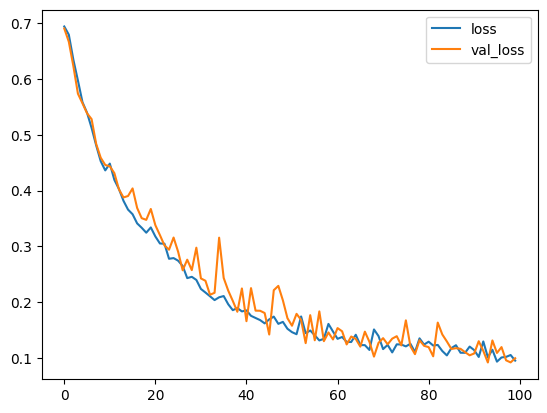

In [23]:
this_history_df[['loss', 'val_loss']].plot()

In [24]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 100, 10)]            0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 100, 10)]            0         []                            
                                                                                                  
 input_1 (InputLayer)        [(None, 1, 1)]               0         []                            
                                                                                                  
 reshape (Reshape)           (None, 1, 100, 10)           0         ['input_2[0][0]']             
                                                                                              

## Base Model Info

In [26]:
x_inp, x_out = graphsage_model.in_out_tensors()

In [27]:
graphsage_keras = Model(inputs=x_inp, outputs=x_out)

In [28]:
graphsage_keras.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 100, 10)]            0         []                            
                                                                                                  
 input_9 (InputLayer)        [(None, 100, 10)]            0         []                            
                                                                                                  
 input_7 (InputLayer)        [(None, 1, 1)]               0         []                            
                                                                                                  
 reshape_6 (Reshape)         (None, 1, 100, 10)           0         ['input_8[0][0]']             
                                                                                            

##### Save the Base Model

In [29]:
# Tensorflow save format to work around issue 
# https://github.com/tensorflow/tensorflow/issues/46659
graphsage_keras.save(Path(setup.temp_path).joinpath('41_DATA_model_base.keras'), save_format='tf')

## Embeddings - Full Graph

Here, I will get NAICS node embeddings for the full graph.  The base model is used to accomplish this.

With my versions of Stellargraph, Keras, Tensorflow, etc., the value returned from HinSAGENodeGenerator.flow isn't compatible with what is expected from HinSAGE.get_in_out_tensors().  The flow value is a NodeSequence, which should generaate the proper tensors, but this isn't working so the tensors have to be extracted from the NodeSequence. 

The NodeSequence generates a tuple.  The first dimension is the batch size.  I either have to iterate over batches or use a batch size large enough to hold all NAICS nodes!  Then, the 0th item holds the tensors needed for prediction.

##### Get full graph

Load the full graph and get the NAICS nodes

In [36]:
with open(Path(setup.temp_path).joinpath('40_DATA_stellargraph_all.pkl'), 'rb') as fin:
      sba_graph_all  = pickle.load(fin)

In [37]:
naics_nodes = sba_graph_all.nodes(node_type='NAICS')

In [39]:
naics_len = len(naics_nodes)
naics_len

1311

##### New generator with large batch size

In [40]:
generator_all = HinSAGENodeGenerator(sba_graph_all, batch_size=naics_len, 
                                 num_samples=setup.gnn_unsup_num_samples,
                                 head_node_type='NAICS',
                                 seed=3434)

In [43]:
flow_all = generator_all.flow(naics_nodes, shuffle=False)

##### Prediction
Unpack the tuple.  Since I've used a large batch size, I only need the 0th item of the 0th item.

In [44]:
embed_out = graphsage_keras.predict(tuple(flow_all)[0][0])

15/41 [=========>....................] - ETA: 0s

2024-01-29 08:06:27.949494: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 5ms/step


In [45]:
print(embed_out.shape)

(1311, 16)


In [58]:
embed_df = pd.DataFrame(embed_out, index=naics_nodes) 
embed_df.columns = [f'emb_{i:03d}' for i in range(len(embed_df.columns))]
embed_df = embed_df.reset_index() \
    .rename(columns={'index':'source'})

In [59]:
embed_df = embed_df.merge(features_naics[['NAICS_orig']].reset_index(),
                          on='source')

In [60]:
print(embed_df.shape)

(1311, 18)


In [63]:
embed_df.head()

,source,emb_000,emb_001,emb_002,emb_003,emb_004,emb_005,emb_006,emb_007,emb_008,emb_009,emb_010,emb_011,emb_012,emb_013,emb_014,emb_015,NAICS_orig
0,n_451120,0.225502,-0.198632,-0.170579,-0.106192,0.016830,0.230369,0.101274,0.021777,-0.353498,0.375800,0.137300,-0.263178,0.172400,0.363915,-0.132745,-0.520729,451120
1,n_621210,0.204367,-0.180015,-0.154591,-0.096239,0.015253,0.208778,0.091782,0.019736,-0.407110,0.339201,-0.168771,0.194777,0.248354,0.337767,0.340730,-0.448278,621210
2,n_811118,0.230902,-0.203388,-0.174663,-0.108735,0.017233,0.235885,0.103700,0.022298,-0.407901,0.377495,-0.089248,-0.036029,0.203817,0.368564,0.148720,-0.527399,811118
3,n_721310,0.192082,-0.169194,-0.145298,-0.090454,0.014336,0.196227,0.086265,0.018549,-0.435066,0.312227,-0.257780,0.195440,0.415653,0.286956,0.190453,-0.419391,721310
4,n_811111,0.243215,-0.214234,-0.183977,-0.114533,0.018152,0.248464,0.109229,0.023487,-0.233343,0.411748,0.089214,-0.121013,-0.208456,0.401039,0.100888,-0.558914,811111


In [62]:
embed_df.to_parquet(Path(setup.temp_path).joinpath('41_DATA_embeddings.parquet'))